In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from remote_llm.gpt_neo_wrap import GPTNeoWrap

from matplotlib import pyplot as plt

small = "EleutherAI/gpt-neo-125M"
model = AutoModelForCausalLM.from_pretrained(small, torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(small, torch_dtype=torch.float16)
model = GPTNeoWrap(model=model, tokenizer=tokenizer)

In [19]:
text = "The quick brown fox jumped over the lazy dog. It was a beautiful day. The fox was very happy."

First we segment the text.

In [20]:
model.displayable_tokens(model.tokens(text))

['The',
 ' quick',
 ' brown',
 ' fox',
 ' jumped',
 ' over',
 ' the',
 ' lazy',
 ' dog',
 '.',
 ' It',
 ' was',
 ' a',
 ' beautiful',
 ' day',
 '.',
 ' The',
 ' fox',
 ' was',
 ' very',
 ' happy',
 '.']

Then we get the token indexes from the text. These are used to look up what embedding we should use later.

In [21]:
model.tokens(text)


[464,
 2068,
 7586,
 21831,
 11687,
 625,
 262,
 16931,
 3290,
 13,
 632,
 373,
 257,
 4950,
 1110,
 13,
 383,
 21831,
 373,
 845,
 3772,
 13]

Here we look at what embeddings those token ids correspond to. We have a big table and the token `464` just looks at the `464`th row of that table and puts that vector first, then we move onto the next token. The final output is a matrix that's has a row for each token, and 784 columns.

As 784 is a large number and the thing will get confusing, we use some math tricks to compress the information a bit. 

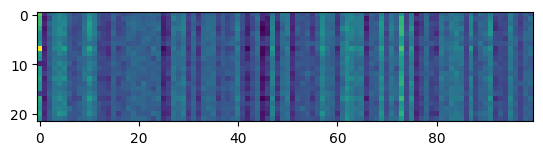

In [22]:
te = model.token_embeddings(text)
plt.imshow(torch.fft.fft(te.to(torch.float32), dim=1).real.detach().cpu().numpy()[:, :100])

Here's the other part of the input, the positional embedding. This encodes which position the token is in, and is static. The positional embedding of the 0th token does not depend on anything but that it's the 0th token.

The final input to the transformer is the positional embedding + the token embedding.

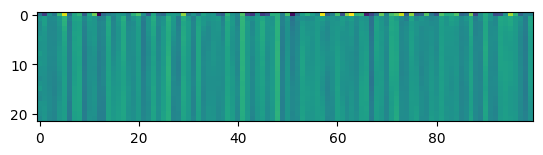

In [23]:
pe = model.position_embeddings(text)
plt.imshow(torch.fft.fft(pe.to(torch.float32), dim=1).real.detach().cpu().numpy()[:, :100])

He's a visualization of the final state of the tokens, just before we give them to the transformer to convert it into a different sequence.

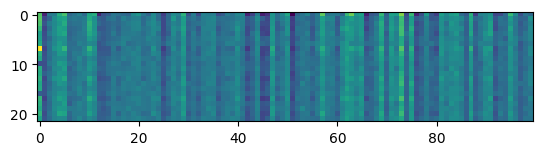

In [24]:
input_embedding = pe + te
plt.imshow(torch.fft.fft(input_embedding.to(torch.float32), dim=1).real.detach().cpu().numpy()[:, :100])

We pass it to the transformer with "forward". There are some other bookkeeping bits, like an attention mask, we haven't mentioned because they aren't important to understanding transformers, so we can't input the `input_embeddings` we came up with in the last cell, so the call is with the text. 

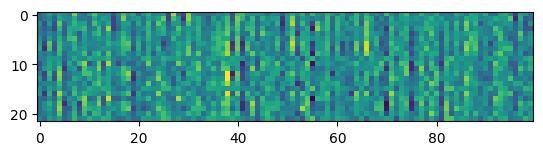

In [25]:
model_output = model.forward(text)
plt.imshow(torch.fft.fft(model_output.to(torch.float32), dim=1).real.detach().cpu().numpy()[:, :100])

In [26]:
model.logits(text)

tensor([[6.1178e-04, 1.9121e-03, 2.6727e-04,  ..., 1.9670e-06, 8.6129e-05,
         1.3618e-03],
        [1.0281e-03, 1.1511e-03, 8.9407e-07,  ..., 0.0000e+00, 4.1723e-07,
         6.6578e-05],
        [3.4738e-04, 2.2173e-04, 2.9802e-06,  ..., 2.3842e-07, 4.1723e-07,
         2.5690e-05],
        ...,
        [1.9073e-06, 1.3709e-06, 0.0000e+00,  ..., 0.0000e+00, 5.9605e-08,
         1.9670e-06],
        [1.0208e-02, 1.4186e-05, 5.9605e-07,  ..., 0.0000e+00, 6.5565e-07,
         1.1235e-04],
        [1.8179e-05, 7.9691e-05, 8.7619e-06,  ..., 0.0000e+00, 5.3644e-07,
         6.3354e-02]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SigmoidBackward0>)

In [27]:
model.logits(text).argmax(dim=-1)[0]

tensor(1944, device='cuda:0')

In [29]:
torch.topk(model.logits(text)[-1,:], k=5, dim=-1)

torch.return_types.topk(
values=tensor([0.6387, 0.6294, 0.6177, 0.5107, 0.2186], device='cuda:0',
       dtype=torch.float16, grad_fn=<TopkBackward0>),
indices=tensor([198, 383, 679, 632, 314], device='cuda:0'))

In [34]:
model.displayable_tokens(torch.topk(model.logits(text)[-1,:], k=5).indices)

['\\n', ' The', ' He', ' It', ' I']

In [ ]:
model.tokenizer.decode(model.logits(text).argmax(dim=-1)[0])

In [ ]:
tokens = tokenizer(text, return_tensors="pt")
tokens.to(model.model.device)
generated = model.model.generate(**tokens)

In [ ]:
generated

In [ ]:
model.get_generational_guts(text, top_k_logits=5, fft=True, embedding_trunkation=100)